In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

print('numpy==' + np.__version__)
print('pandas==' + pd.__version__)
print('matplotlib==' + matplotlib.__version__)
print('tensorflow-macos==' + tf.__version__)
print('sklearn==' + sklearn.__version__)

numpy==1.19.5
pandas==1.3.2
matplotlib==3.4.3
tensorflow-macos==2.6.0
sklearn==1.1.1


In [3]:
data_path = 'data/BTC_with_Reddit_1min.csv'
data = pd.read_csv(data_path).drop(['time_period_start', 'time_period_end'], axis=1)
# data = pd.read_csv(data_path).drop(['10min_TimeStart', 'time_period_end', 'time_open', 'time_close', 'vander_pos', 'vander_neg', 'vander_neu', 'vander_compound', 'textblob_polarity', 'textblob_subjectivity'], axis=1)
# data = pd.read_csv(data_path).drop(['Unnamed: 0', 'timestamp'], axis=1)
# data = data[:54291]
data.head()

,price_open,price_high,price_low,price_close,volume_traded,reddit_sentiment,pos_keywords_occur,neg_keywords_occur
0,38320.00,38417.80,38319.99,38394.98,92.019354,0.0,0,0
1,38381.19,38381.19,38230.81,38257.69,3.200295,0.0,0,0
2,38251.68,38361.29,38247.05,38361.29,3.536984,0.0,0,0
3,38375.70,38485.00,38375.70,38455.46,9.787897,0.0,0,0
4,38446.95,38556.27,38446.95,38556.27,30.134611,0.0,0,0


In [4]:
data_features = data.drop(['price_close'], axis=1)
data_labels = data['price_close']

# data = data.to_numpy()

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))


train_size1 = int(0.7 * len(label))
train_size2 = int(0.9 * len(label))

In [5]:
print(data_features[:3])
print(data_labels[:3])

   price_open  price_high  price_low  volume_traded  reddit_sentiment  \
0    38320.00    38417.80   38319.99      92.019354               0.0   
1    38381.19    38381.19   38230.81       3.200295               0.0   
2    38251.68    38361.29   38247.05       3.536984               0.0   

   pos_keywords_occur  neg_keywords_occur  
0                   0                   0  
1                   0                   0  
2                   0                   0  
0    38394.98
1    38257.69
2    38361.29
Name: price_close, dtype: float64


In [6]:
def split_data(f, l):
    delay = 60
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

X_train, y_train = split_data(feature[:train_size1], label[:train_size1])
X_train2, y_train2 = split_data(feature[train_size1:train_size2], label[train_size1:train_size2])
X_test, y_test = split_data(feature[train_size2:], label[train_size2:])

In [7]:
models = [
    keras.Sequential([
        layers.GRU(128),
        layers.Dense(1)
    ]) for i in range(5)
]

2022-09-07 07:51:59.465576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 07:51:59.516765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 07:51:59.517160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 07:51:59.518302: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
for i, model in enumerate(models):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=2048,
                        validation_data=(X_test, y_test),
                        callbacks=[keras.callbacks.ModelCheckpoint('gru'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-09-07 07:52:01.160105: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-07 07:52:03.103059: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400


187/187 [==============================] - 7s 27ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 2.8342e-06 - val_root_mean_squared_error: 0.0017

Epoch 00001: val_root_mean_squared_error improved from inf to 0.00168, saving model to gru0.h5
Epoch 2/50
187/187 [==============================] - 5s 25ms/step - loss: 5.2565e-06 - root_mean_squared_error: 0.0023 - val_loss: 2.2410e-06 - val_root_mean_squared_error: 0.0015

Epoch 00002: val_root_mean_squared_error improved from 0.00168 to 0.00150, saving model to gru0.h5
Epoch 3/50
187/187 [==============================] - 5s 25ms/step - loss: 4.2030e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.8837e-06 - val_root_mean_squared_error: 0.0014

Epoch 00003: val_root_mean_squared_error improved from 0.00150 to 0.00137, saving model to gru0.h5
Epoch 4/50
187/187 [==============================] - 5s 25ms/step - loss: 3.4905e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.4655e-06 - val_root_mean_squared_error: 0.

In [11]:
models = []
for i in range(5):
    # models.append(tf.keras.models.load_model('../Trained_Models/gru'+str(i)+'.h5'))
    models.append(tf.keras.models.load_model('gru'+str(i)+'.h5'))

In [12]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test))

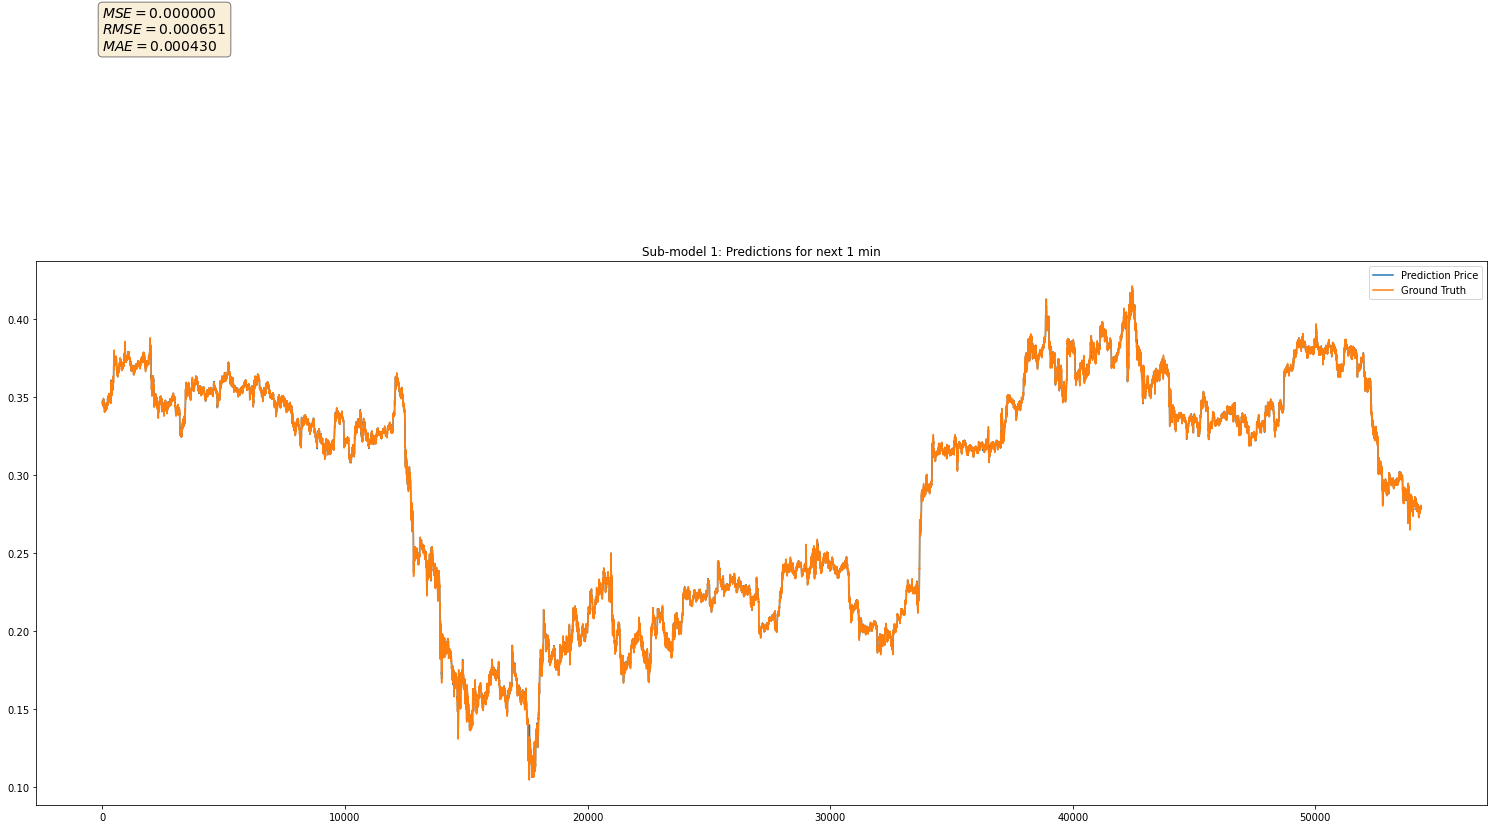

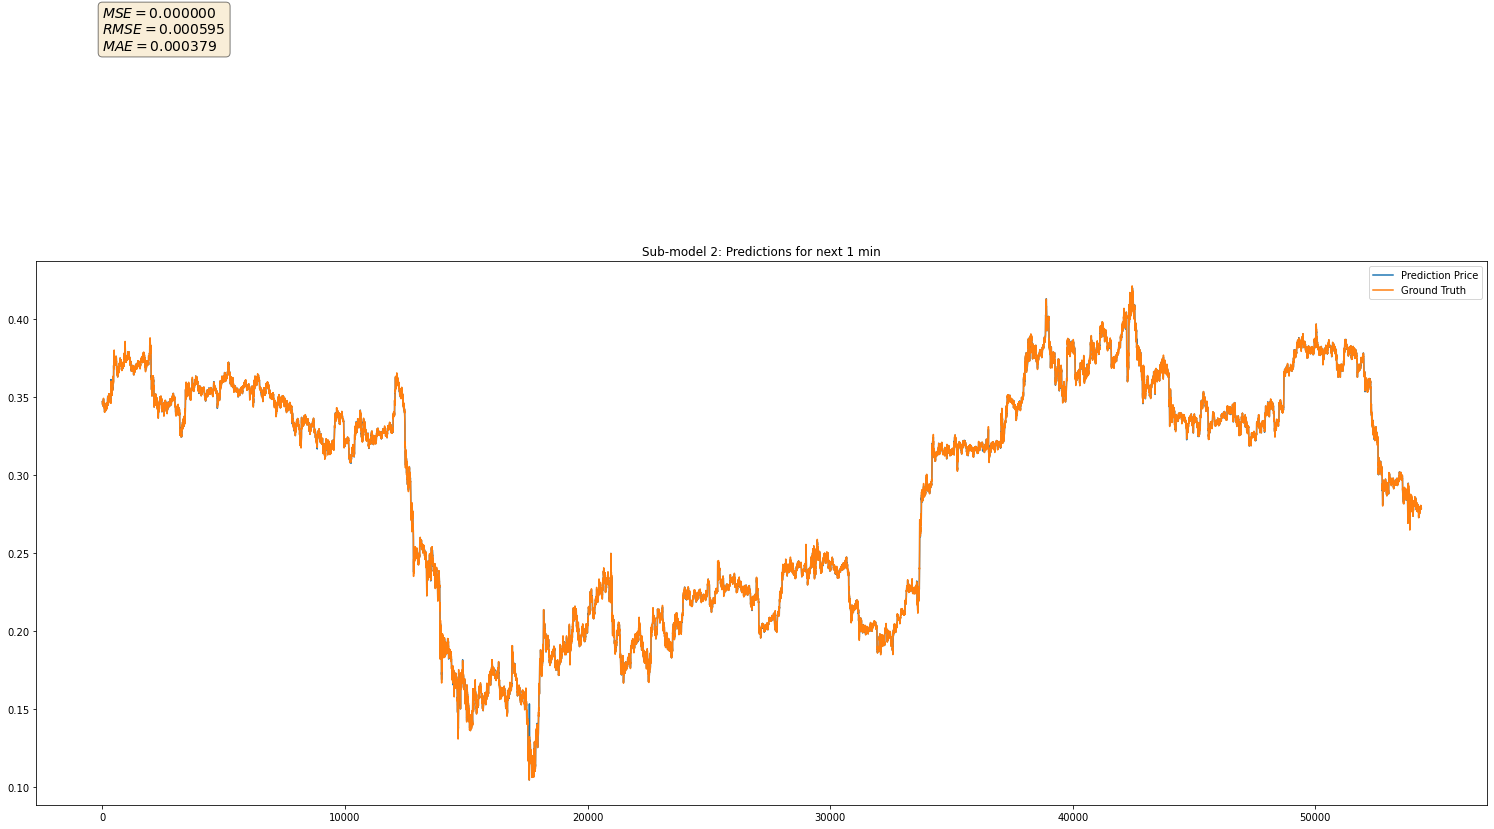

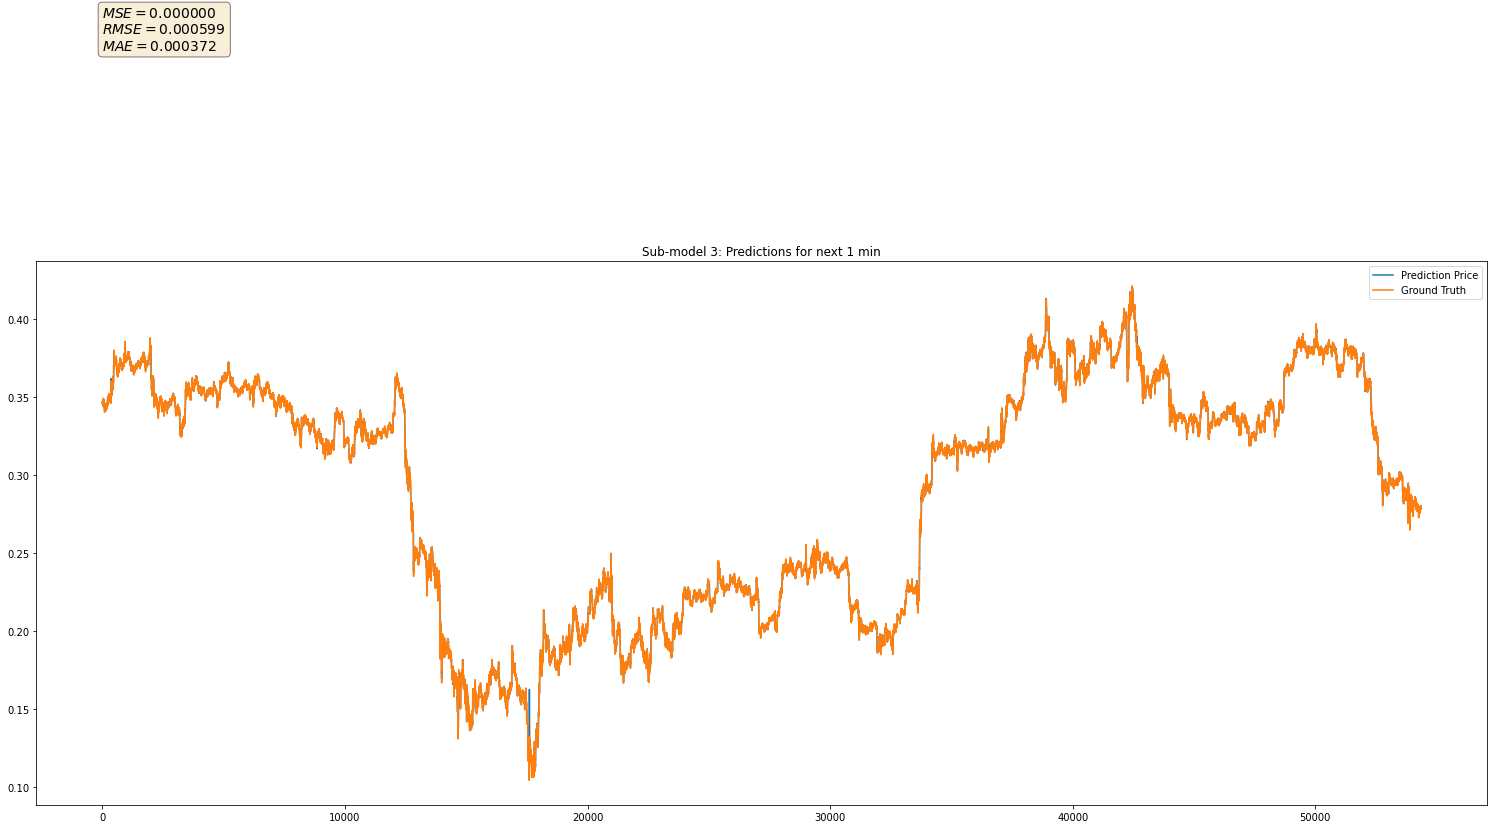

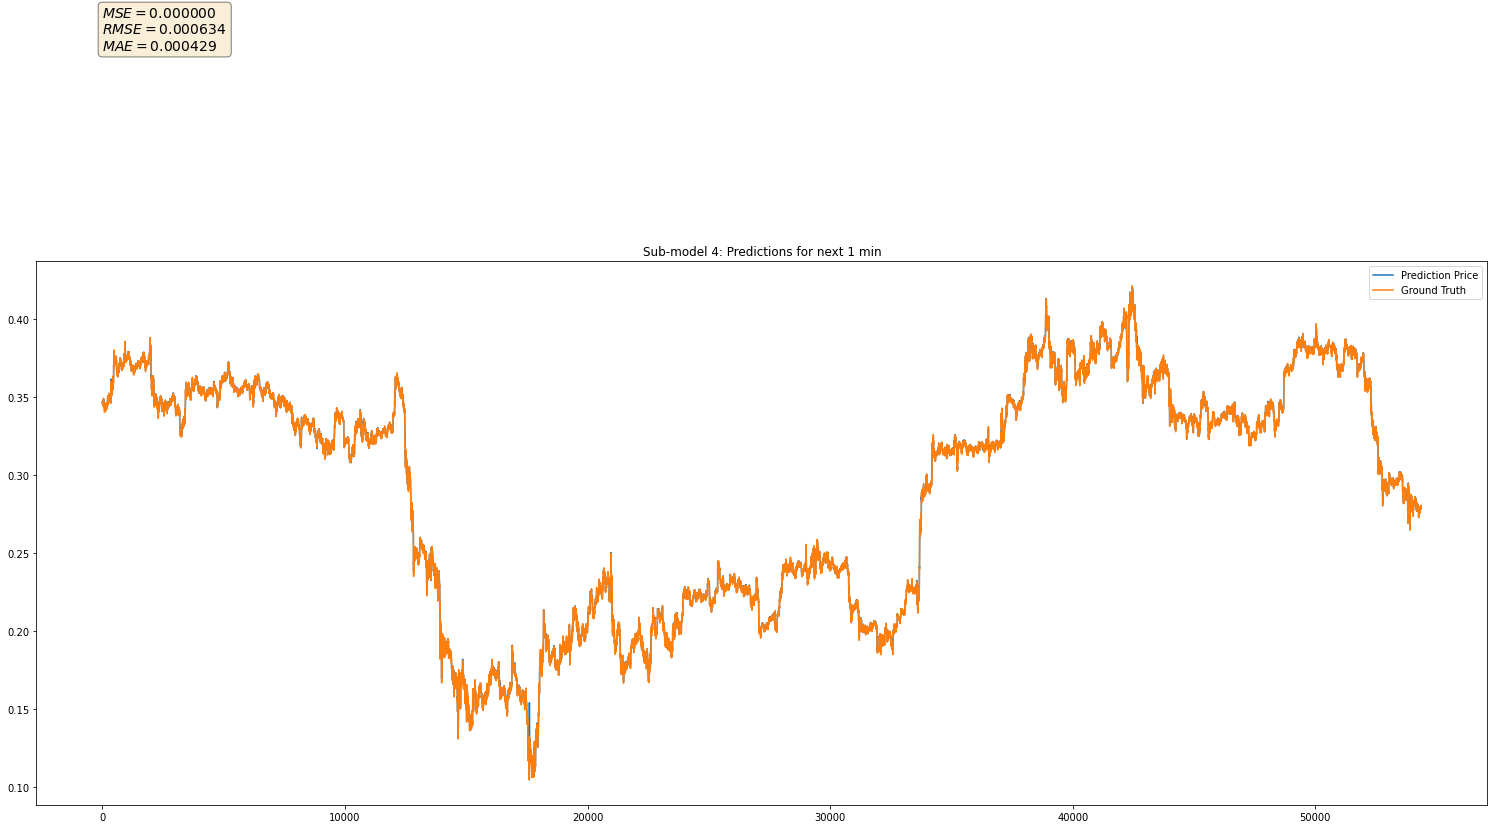

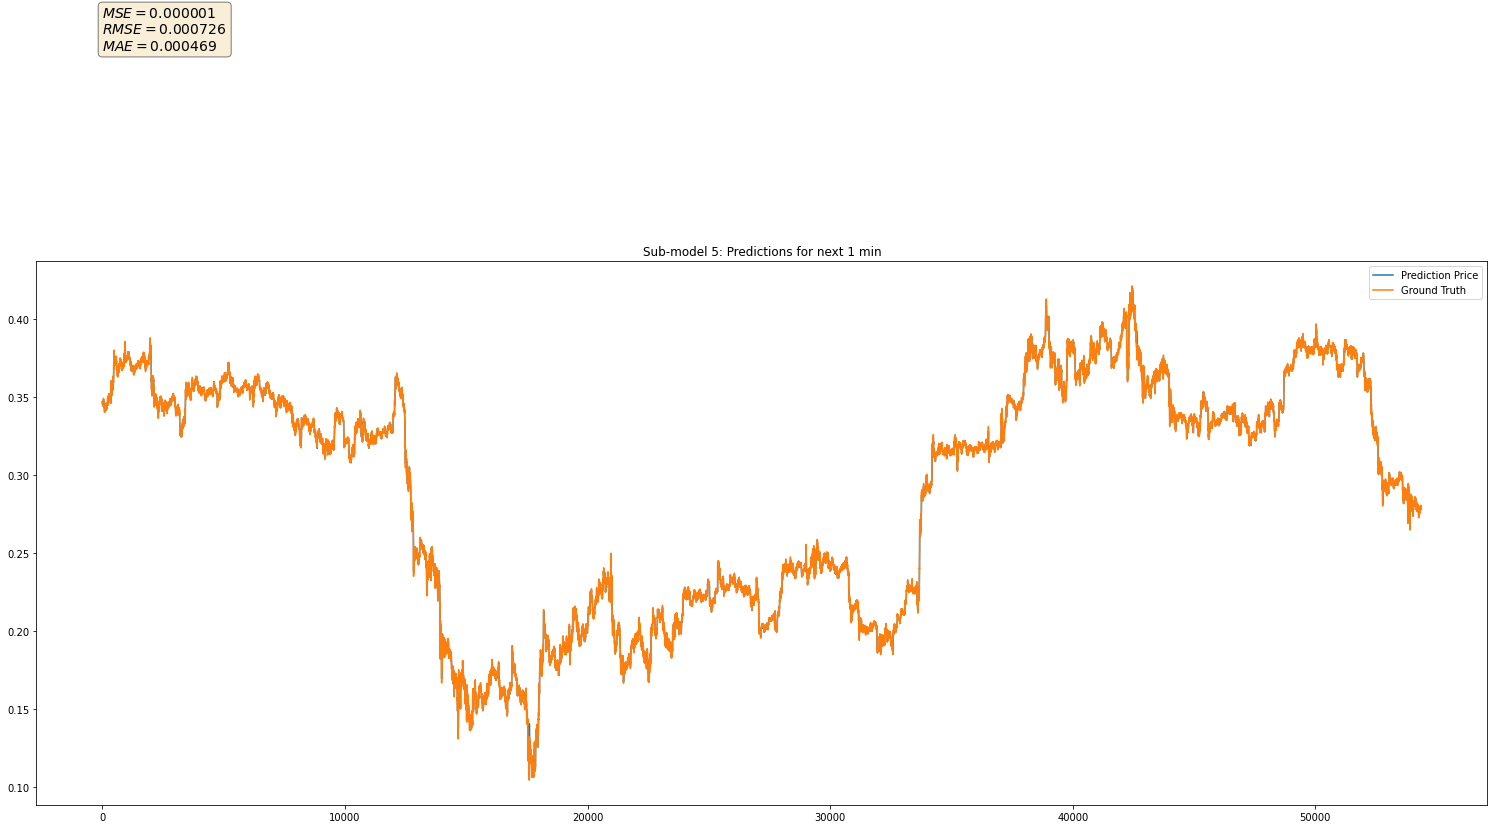

In [13]:
# prediction = model.predict(X_test)
for i, prediction in enumerate(predictions):
    mse = mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mae = mean_absolute_error(y_test, prediction)

    metrics = '\n'.join((
        '$MSE=%f$' % (mse),
        '$RMSE=%f$' % (rmse),
        '$MAE=%f$' % (mae)
    ))

    plt.figure(figsize=(26, 10))
    plt.plot(prediction, label='Prediction Price')
    plt.plot(y_test, label='Ground Truth')
    plt.legend()
    plt.title('Sub-model ' + str(i+1) + ': Predictions for next 1 min')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.1, 0.6, metrics, fontsize=14,
            verticalalignment='top', bbox=props)

    # plt.savefig('no_senti.png', dpi=500)
    plt.show()

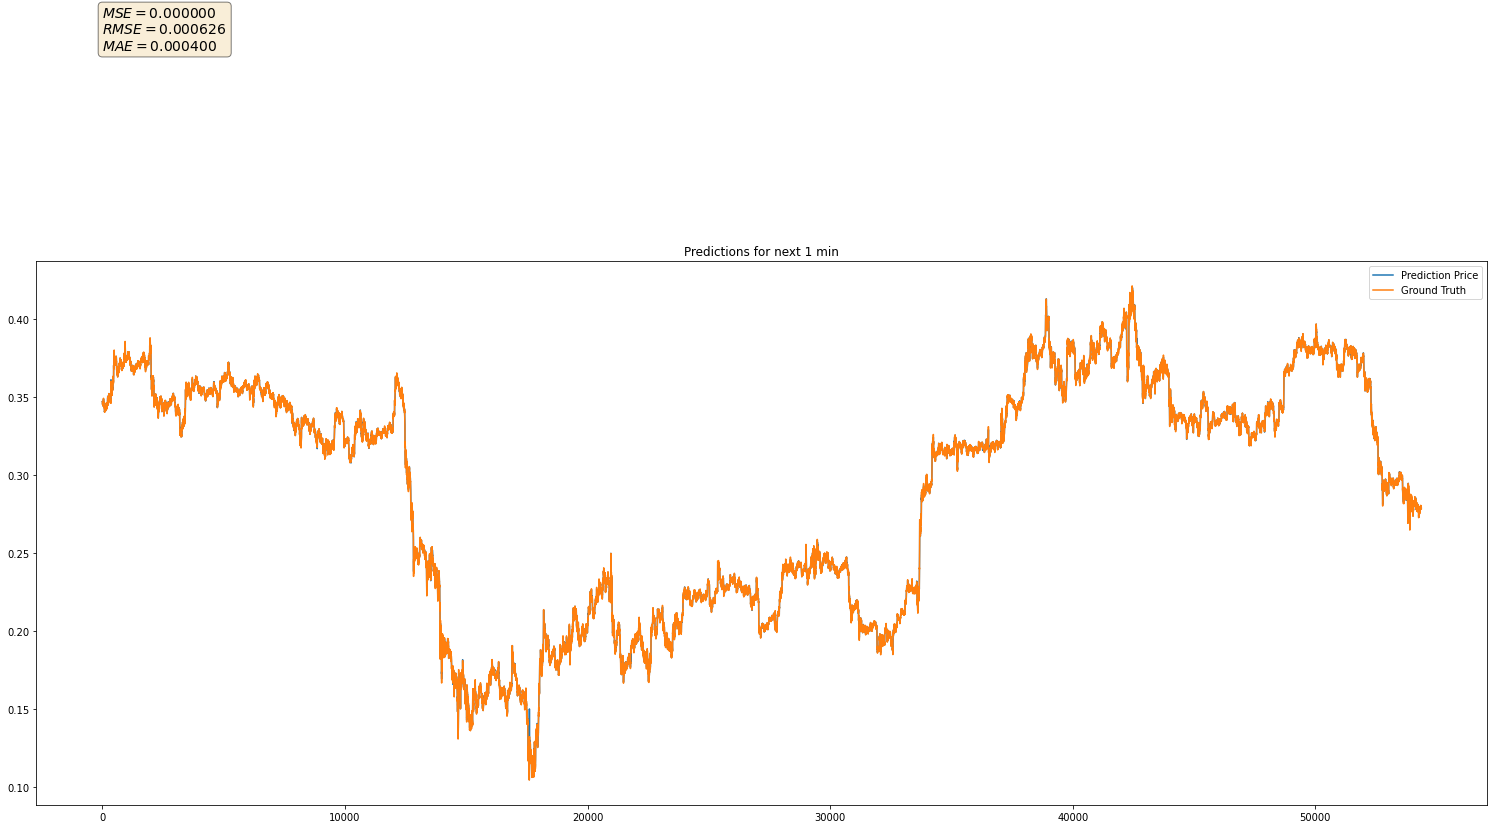

In [14]:
prediction = np.mean(np.array(predictions), axis=0)
mse = mean_squared_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)
mae = mean_absolute_error(y_test, prediction)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(prediction, label='Prediction Price')
plt.plot(y_test, label='Ground Truth')
plt.legend()
plt.title('Predictions for next 1 min')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.1, 0.6, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

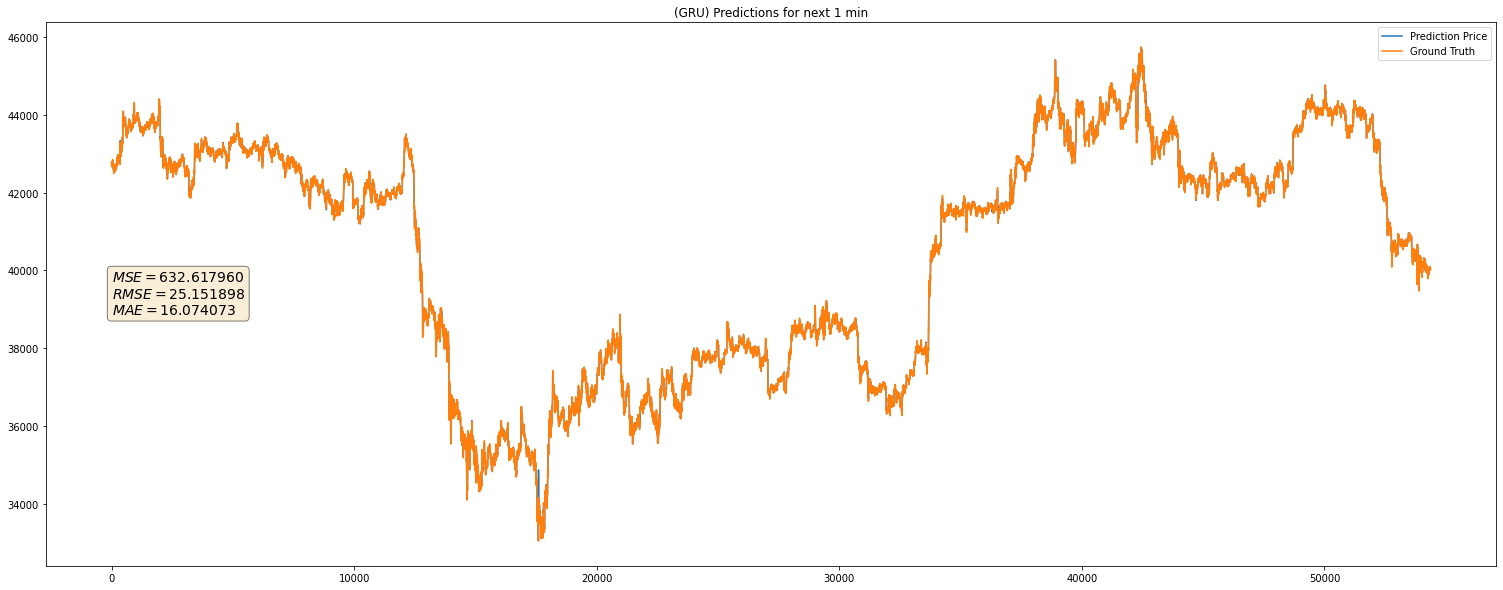

In [15]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('(GRU) Predictions for next 1 min')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 40000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()